# Lab1: Binary image classifier

## 1. Setup
Install fastbook and setup Google drive connection.

In [42]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Import necessary libraries

In [43]:
from fastbook import *
from fastai.vision.widgets import *

## 2. Download images 
Use Azure image search or DuckDuckGo to download 150 images of each class. Save images to Google drive.

In [44]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')

tomato_types = 'green','ripe'
path = export_path/'tomatoes_ddg'
export_path.ls()


(#1) [Path('/content/gdrive/MyDrive/Colab Notebooks/Copy of dl-lab0.ipynb')]

### 2.1 Try it out
Similar to the lecture notebook, try out your query and plot a few of the resulting images to verify that your search returns sensible images.

Green tomatoes: 

0: http://www.howtohaveitall.net/wp-content/uploads/2015/10/green-tomatoes.jpg
406 Client Error: Not Acceptable for url: http://www.howtohaveitall.net/wp-content/uploads/2015/10/green-tomatoes.jpg
1: https://1.bp.blogspot.com/-h3F_Eyu7fBI/UhWNIpg2KiI/AAAAAAAAAZ4/S3u2TIeQAMk/s1600/016.JPG
2: http://2.bp.blogspot.com/-gjy3GAfikP4/UmqfrN7Nv0I/AAAAAAAAUVw/lnY96Dj418o/s1600/green+tomatoes2.JPG
3: http://hollyandtheivy.co.uk/wp-content/uploads/2017/04/green-tomato.jpg
4: http://cdn.sheknows.com/articles/2012/10/green-tomatoes-600.jpg


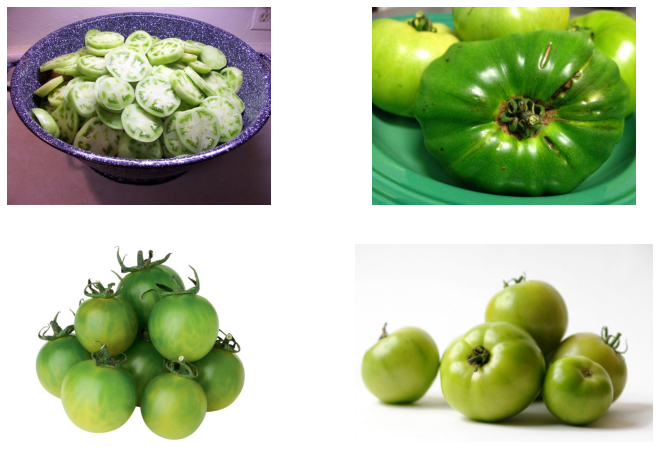

In [88]:

print('Green tomatoes: \n')

#create figures
f, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()
ax_i = 0
img_i = 0

#get a list of image urls to display from our previous search/download 
urls = search_images_ddg('green tomatoes', max_images=5)

#iterate our tomatoes to display
while ax_i < len(axes) and img_i < len(urls):
    try:
      url = urls[img_i]
      print(f'{img_i}: {url}')
      image_data = requests.get(url)
      image_data.raise_for_status()
      image = Image.open(BytesIO(image_data.content)) 

      axes[ax_i].imshow(image)
      axes[ax_i].axis("off")
      ax_i += 1 # next axis
    except requests.exceptions.RequestException as e:
      print(e)
    finally:
      img_i += 1 # next image, especially when exception occured
plt.show()

      


### 2.2 Get images for the two classes
Download 150 images of each class. Save images to Google drive.  
Remove any corrupt images using `verify_images()`.

In [46]:
if not path.exists():
    path.mkdir()
    for o in tomato_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} tomatoes', max_images=150)
        download_images(dest, urls=results)

In [47]:
#change all file types to .jpg
for o in tomato_types:
  dest = (path/o)
  for filename in dest.ls():
    if filename.suffix.lower() != '.jpg':
      print(filename)
      filename.rename((filename.parent/f"{filename.stem}.jpg"))

/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000008.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000032.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000039.cms
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000030.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000047.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000061.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000064.jpeg
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000059.jpeg
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000086.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000115.jpeg
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000124.jpeg
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000164.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/00000168.png
/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/green/0

In [48]:
#get all images and checks for ones that have failed to download properly
fns = get_image_files(path)
failed = verify_images(fns)

#display failed files
print(f'list of failed files: {failed}')

#remove failed files
failed.map(Path.unlink) # map() applies the function to all elements in the list. unlink() deletes the file.

#check that our failed files have been removed
fns = get_image_files(path)
print(f'list of failed files: {verify_images(fns)}')


list of failed files: [Path('/content/gdrive/MyDrive/Colab Notebooks/tomatoes_ddg/ripe/00000004.jpg')]
list of failed files: []


## 3. Setup image loaders
Setup image loaders, use 20% of images for validation, and show one batch for each training and validation dataset.

In [49]:
tomatoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #how to train-valid split
    get_y=parent_label, # get the label from the directory name
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # random crop at each iteration, resize to 224x224
    batch_tfms=aug_transforms()) #a set of transformations like  rotation, flipping, perspective warping, brightness changes and contrast changes

path = export_path/'tomatoes_ddg'
dls = tomatoes.dataloaders(path)

There is 291 training images
There is 72 validation images


This is a training set batch


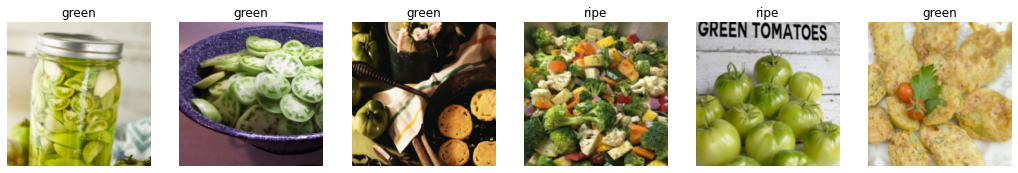

This is a validation set batch


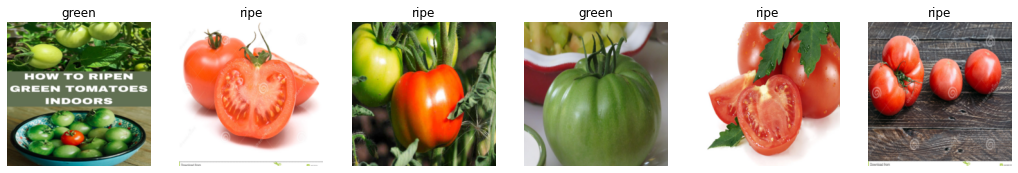

In [61]:
#print total number of images in each set
print(f'There is {(dls.train.n)} training images')
print(f'There is {dls.valid.n} validation images')

#print a batch from training and validation sets
print('\n\nThis is a training set batch')
dls.train.show_batch(max_n = 6, nrows = 1)
plt.show()
print('This is a validation set batch')
dls.valid.show_batch(max_n = 6, nrows = 1)
plt.show()

In [69]:
#This block of code is to determine how many images of each category is in the training and validation sets. 
X1, y1 = zip(*dls.valid_ds)
X2, y2 = zip(*dls.train_ds)

valid_ripe = len([i for i in y1 if i == 1]);
valid_green = len([i for i in y1 if i == 0]);
train_ripe = len([i for i in y2 if i == 1]);
train_green = len([i for i in y2 if i == 0]);

print(f'Our classes are {dls.vocab}')
print(f'There are {train_ripe} ripe tomato images and {train_green} green tomato images in the training set')
print(f'There are {valid_ripe} ripe tomato images and {valid_green} green tomato images in the validation set')

Our classes are ['green', 'ripe']
There are 147 ripe tomato images and 144 green tomato images in the training set
There are 39 ripe tomato images and 33 green tomato images in the validation set


**Question 1:** How many images of each class are in trainging and validation sets?

 - There are 292 training images and 72 validation images.
 - There are more than 150*2 images because DDG grabs 'approximately `max_images`'. This resulted in more than the requested total for me. 

## 4. Setup cnn learner
Setup a cnn learner with the dataloaders, `resnet18` architecture and `error_rate` as metric.

In [52]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

## 5. Train binary classifier
Fine tune for 10 epochs and show results.

In [53]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.343902,1.003098,0.305556,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.539190,0.411053,0.111111,00:15
1,0.457059,0.256208,0.055556,00:15
2,0.389653,0.245367,0.041667,00:15
3,0.342507,0.249180,0.027778,00:15
4,0.305089,0.284392,0.027778,00:15
5,0.266080,0.309848,0.027778,00:15
6,0.239966,0.325254,0.027778,00:15
7,0.216059,0.331186,0.027778,00:15
8,0.197526,0.329696,0.027778,00:15
9,0.179399,0.323844,0.027778,00:15


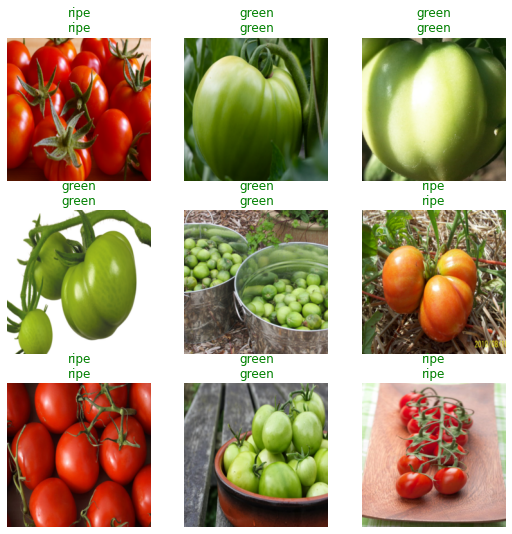

In [54]:
learn.show_results()

**Question 2:** Is the model overfitting? Why, why not?

- The model appears to be overfitting by the 10th epoch. Our model begins to overfit after the 3rd epoch. We can tell the model is overfitting because we can see the validation loss begins to increase on the 4th epoch while the training loss continues to go down. This tells us that the model is now memorizing the training set too much and as a result is losing ability to correctly identify images it hasn't seen before. 

## 6. Analyze results

Plot confusion matrix.

Plot top 5 losses.


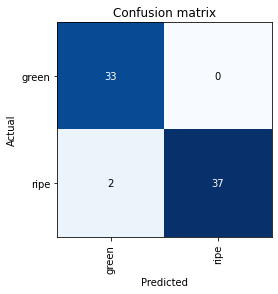

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

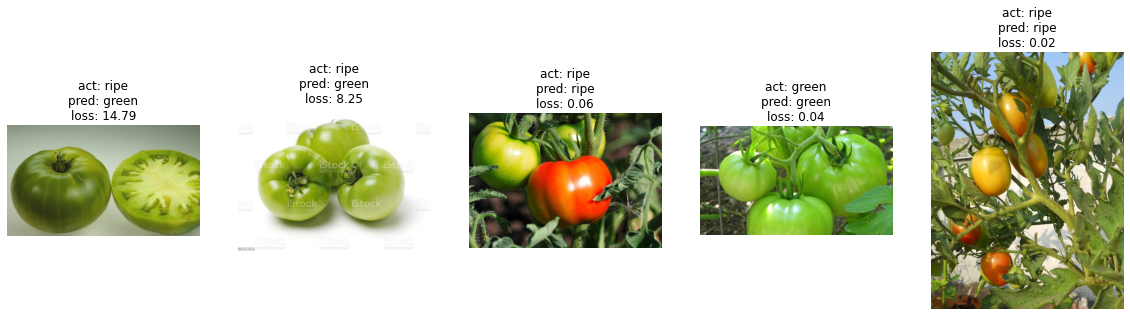

In [56]:
k=5
losses, idxs = interp.top_losses(k)
predicteds = interp.preds[idxs].argmax(axis=1)
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(20, 10))

for ax, id, loss, pred in zip(axs, idxs, losses, predicteds):
    img, actual = dls.valid_ds[id]
    img.show(ctx=ax)
    ax.set_title(f'act: {dls.vocab[actual.item()]}\npred: {dls.vocab[pred]}\nloss: {loss:.2f}')

**Question 3:** How many false positive, false negative errors?

- There were 5 false negatives
- There were 0 false positives

## 7. Summary and Conclusion

Summarize:
- **Type of classifier trained:**
  -
- **Number of images of each class in the training validation sets:**
  - There are 292 training images and 72 validation images.
  - There are 148 ripe tomato images and 144 green tomato images in the training set
  - There are 31 ripe tomato images and 41 green tomato images in the validation set
- ***Error rate achieved:***
  -


Conclusion:
- Are there any problems with data/labeling?
- Are you satisfied with model performance? Why, why not?

  - It appears that the only images that failed were incorrectly labeled from the initial search. It is suspected that the content that the images were uploaded to the internet under played a role in the search engine incorrectly capturing these images under the provided key word search. Fortunately, FastAI has a feature to remove these images.
  - I would say I am satisfied with the initial results since they are 100% accurate with the exception of the images incorrectly labeled. Field testing would provide a better measure of model performance though.


## 8. Reflection
Include a sentence or two about 
- what you liked or disliked, 
- found interesting, confusing, challangeing, motivating 

while working on this assignment:


I really liked the ability to customize this assignment to our interests as well as having easily translatable notes for our first dip into deep learning. Overall the assignment was very straight forward and well supported by the textbook, lecture videos and notes.